# Tutorial on using the CMBFields objects

You should go through an evaluate everything, including these first two cells:

In [1]:
push!(LOAD_PATH, pwd()*"/../src")
using BayesLensSPTpol: class
using CMBFields
using PyPlot
using PyCall


#can comment this out if you don't care about adjusting plot looks:
@pyimport seaborn as sns
sns.set_context("notebook",font_scale=1.4,rc=Dict("lines.markeredgewidth"=>1))
sns.set_palette("colorblind")
# sns.set_style("darkgrid")
sns.set_style("ticks",Dict("xtick.direction"=>"in","ytick.direction"=>"in","image.cmap"=>"jet"))

In [2]:
cls = class();

The `CMBFields` package gives you a bunch of objects with which you can manipulate CMB fields (T, E, $\phi$, etc...) and operators acting on those fields. Currently just a flat sky spin-0 field (i.e. T or $\phi$) is implemented, but the idea is to extend this to spin-2 fields (E/B), and eventually even curved sky pixelization, and it'll all work transparently behind the scenes. 

For spin-0 flat sky, we first specify the pixelzation we want, 

In [3]:
nside = 256
θpix = 1 # units of arcmin
Pix = Flat{θpix,nside}

CMBFields.Flat{1,256}

Then we have two objects, one which stores a map, and another which stores the Fourier transform of a map:

In [4]:
n = FlatS0Map{Float64,Pix}(randn(nside,nside))
s = FlatS0Fourier{Float64,Pix}(randn(round(Int,nside/2+1),nside));

One of the basic functionalities provided is that you can do operations on these objects and any conversions between Map/Fourier space are done automatically. For example, if you add them, they are automatically converted to a common basis.

(Note:map+fourier always gives a map by default)

In [5]:
@show typeof(n+n)
@show typeof(n+s)
@show typeof(s+s);

typeof(n + n) = CMBFields.FlatS0Map{Float64,CMBFields.Flat{1,256}}
typeof(n + s) = CMBFields.FlatS0Map{Float64,CMBFields.Flat{1,256}}
typeof(s + s) = CMBFields.FlatS0Fourier{Float64,CMBFields.Flat{1,256}}


You can also do arithmetic on them,

In [6]:
y = 2*n + s/5 + 1;

To get the underlying data (e.g. to plot it), use `[:Tx]` to get the map or `[:Tl]` to get the Fourier transform. If you do `[:Tx]` on a Fourier object or `[:Tl]` on a Map object, again the transform is done automatically. 

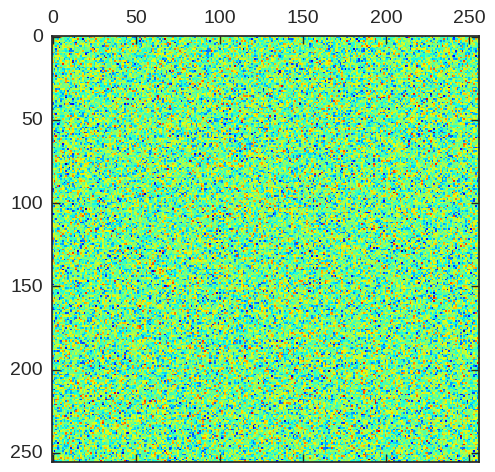

PyObject <matplotlib.image.AxesImage object at 0x7f230710ef60>

In [7]:
s[:Tx] |> matshow

We also have object which represent linear operations on these fields. The covariance of a field is one such linear operator, and we can construct  objects which are a covariance which is diagonal in a particular basis. For example, and signal covariance which is diagonal in Fourier space and the noise covariance which is diagonal in Map space. 

In [20]:
S = Cℓ_to_cov(FlatS0FourierDiagCov{Float64,Pix}, cls[:ell], cls[:tt]);
S.Cl[S.Cl.==0] = 1e-8 #threshold S so we can safely do S^-1

# add a "mask" by blowing up the noise in the center of the map
μKarcminT = 5
Ωpix = deg2rad(θpix/60)^2
N = FlatS0MapDiagCov{Float64,Pix}(fill(μKarcminT^2 * Ωpix,(nside,nside)));
mi,me = (round(Int,(0.5+x*0.25)*nside) for x=[-1,1])
N.Cx[mi:me,mi:me] *= 1000000;

We can then draw realizations of fields from these covariances:

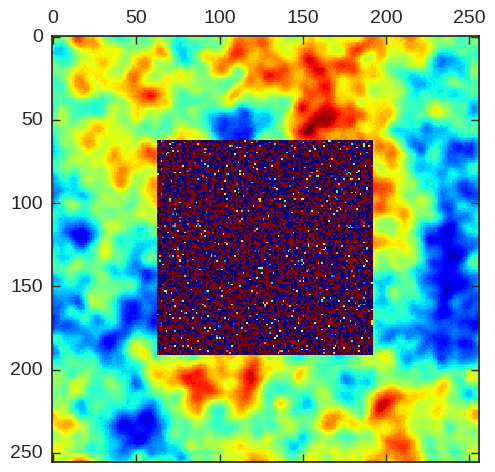

PyObject <matplotlib.image.AxesImage object at 0x7f22e9b8c080>

In [21]:
s = simulate(S)
n = simulate(N) / √Ωpix # <-- TODO: fix needing this factor
d = s + n;

matshow(d[:Tx], vmin=-300, vmax=300)

Similarly, we can operate on them with the covariances, and if needed, they are converted into the basis in which the covariance in diagonal so as to perform the operation:

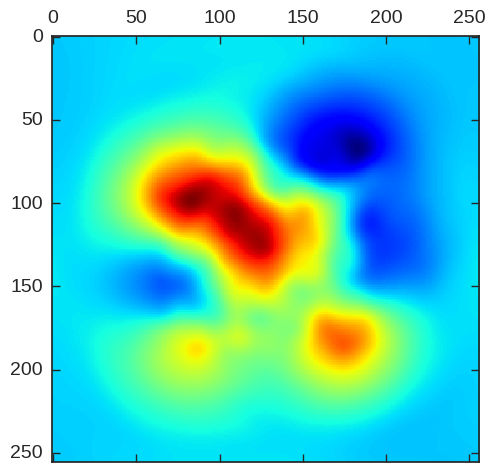

PyObject <matplotlib.image.AxesImage object at 0x7f22e9af1438>

In [22]:
(S*n)[:Tx] |> matshow

The covariances can be be combined into arbitrary expression which can then be applied to fields:

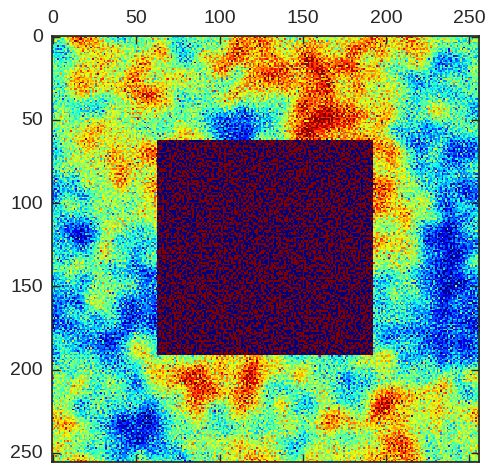

PyObject <matplotlib.image.AxesImage object at 0x7f22e9ad2860>

In [23]:
A = 1+N*S^(-1)
matshow((A*s)[:Tx], vmin=-300, vmax=300)

Finally, when we need to feed these things into certain algortihms (like conjugate gradient, etc...), we need normal vectors and things operating on vectors. For this we have three things, 

* `x[:]` gives a field as a vector (depending on if `x` is Map or Fourier basis)
* `A[~x]` takes an operator and returns something which on a vector of the type produced by `x[:]`, i.e. on a Map is x is a Map and vice-versa
* `v[~x]` takes a vector `v` and turns it into a Field object assuming

That is, `A*x` is equivalent to `(A[~x] * x[:])[~x]`.

The `~` in `A[~n]` is supposed to mean A acting on something that looks like `n`, hence `~n`.

In [24]:
s[:]

33024-element Array{Complex{Float64},1}:
           -2.3373e-7+0.0im        
            0.0193381-0.0127436im  
           0.00296159+0.00422753im 
          -0.00771705-0.00698579im 
           0.00291157-0.00616453im 
          0.000865183-0.00450276im 
          -8.81821e-5+0.00178931im 
           0.00125242+0.000596915im
          0.000450177-0.00270081im 
           0.00134753+0.00146925im 
          0.000502137-0.00128446im 
           3.75202e-5+0.00135937im 
          0.000407058-0.00103754im 
                     ⋮             
 -1.98028e-7-1.24597e-6im          
 6.20605e-11-7.48175e-7im          
 -6.89245e-7-7.84781e-7im          
  1.36519e-7-1.83439e-7im          
   1.9334e-6+1.44378e-6im          
  1.19905e-6-3.23605e-7im          
  9.40185e-7+9.61422e-7im          
   4.80217e-7-1.4135e-7im          
 -7.63084e-7+3.39504e-7im          
  1.83988e-7-5.13615e-7im          
 -6.35564e-7-6.72497e-7im          
 -9.25393e-8-8.65718e-8im          

In [25]:
A[~s] * s[:]

33024-element Array{Complex{Float64},1}:
  -12.8942+0.0im     
    7.4293+2.50975im 
   4.51666+0.348348im
  -11.3552-2.21755im 
   4.76477-2.65601im 
   8.13656+6.54795im 
  -11.4866-1.70019im 
   2.53812-4.29329im 
   5.14541+1.21854im 
  -3.51049+4.91467im 
 0.0382006-2.5156im  
 -0.660174-4.15426im 
 -0.563525+2.4278im  
          ⋮          
  -8.23441-8.7404im  
   96.3351-168.065im 
  -69.3615+187.377im 
  -95.0778-98.6981im 
    195.98+80.9132im 
  -113.566-117.645im 
  -13.2892+82.3744im 
   35.4621-3.05523im 
  -12.1248-14.8131im 
   38.4402+12.2278im 
  -56.4203-80.9595im 
   6.41164+139.877im 

In [26]:
typeof((A[~s] * s[:])[~s])

CMBFields.FlatS0Fourier{Float64,CMBFields.Flat{1,256}}

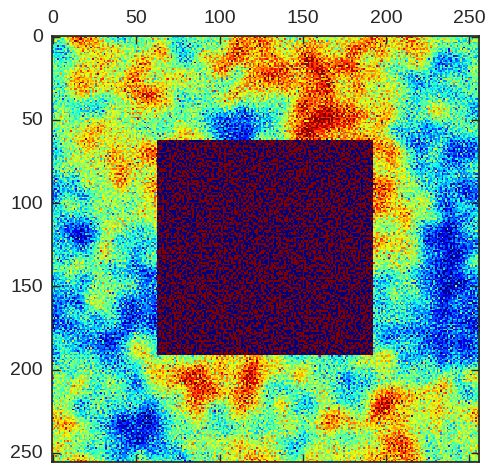

PyObject <matplotlib.image.AxesImage object at 0x7f22e9a2fc88>

In [27]:
matshow((A[~s] * s[:])[~s][:Tx], vmin=-300, vmax=300)

We can put this together to quickly code up a conjugate gradient solution of the Wiener filter using the `cg` function from `IterativeSolvers`.

In [28]:
using IterativeSolvers

# the form in which we apply the Wiener filter
A = (1+S^(1/2)*N^(-1)*S^(1/2))
b = S^(1/2)*N^(-1)*d

# note the use of the ~ notation
x = cg(A[~b], b[:], tol=1e-3)[~b]
swf = S^(1/2)*x;

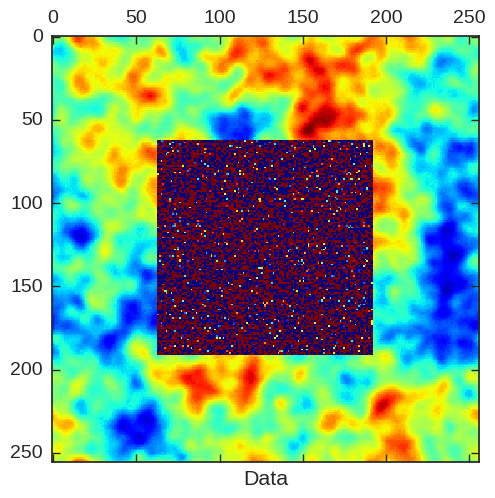

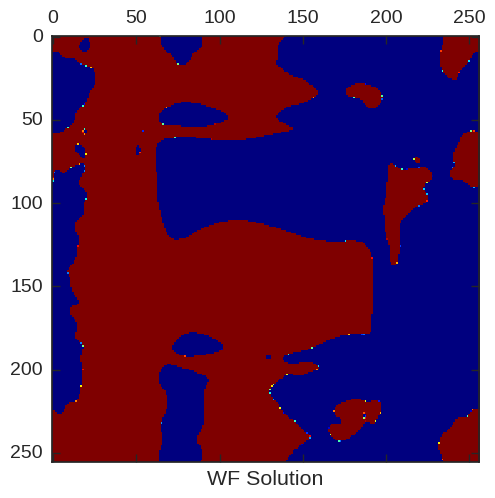

PyObject <matplotlib.text.Text object at 0x7f22e99a3278>

In [29]:
matshow(d[:Tx], vmin=-300, vmax=300); xlabel("Data")
matshow(swf[:Tx], vmin=-300, vmax=300); xlabel("WF Solution")